In [33]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import joblib

# Get paths
NOTEBOOK_DIR = Path().absolute()
PROJECT_ROOT = NOTEBOOK_DIR.parent
DATA_DIR = PROJECT_ROOT / 'data'
PROCESSED_DIR = DATA_DIR / 'processed'
OUTPUT_DIR = PROJECT_ROOT / 'output'

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# File paths
TRANSACTIONS_CLEAN = PROCESSED_DIR / 'transactions_clean.csv'
FRAUD_FLAGGED = PROCESSED_DIR / 'fraud_flagged.csv'
FRAUD_MODEL = OUTPUT_DIR / 'fraud_model.pkl'
SCALER = OUTPUT_DIR / 'scaler.pkl'

# Load data
transactions = pd.read_csv(TRANSACTIONS_CLEAN)

print(f"Loaded {len(transactions)} transactions")
print(f"Fraud rate: {transactions['is_fraud'].mean()*100:.2f}%")

Loaded 14082 transactions
Fraud rate: 5.33%


In [34]:
print("="*50)
print("FEATURE PREPARATION")
print("="*50)

features = [
    'amount',
    'is_weekend',
    'is_high_value',
    'is_new_customer',
    'days_since_signup',
    'shipping_billing_mismatch'
]

X = transactions[features].copy()
y = transactions['is_fraud'].copy()

# Handling any missing values in features
X = X.fillna(0)

print(f"\nFeatures: {features}")
print(f"\nDataset shape: {X.shape}")
print(f"Target distribution:")
print(y.value_counts())
print(f"\nFraud rate: {y.mean()*100:.2f}%")

FEATURE PREPARATION

Features: ['amount', 'is_weekend', 'is_high_value', 'is_new_customer', 'days_since_signup', 'shipping_billing_mismatch']

Dataset shape: (14082, 6)
Target distribution:
is_fraud
False    13332
True       750
Name: count, dtype: int64

Fraud rate: 5.33%


In [35]:
print("="*50)
print("MODEL TRAINING - XGBOOST")
print("="*50)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculate scale_pos_weight for imbalanced classes
# This tells XGBoost to weight fraud cases more heavily
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

print(f"\nClass imbalance ratio: {scale_pos_weight:.2f}")
print("Training XGBoost model with balanced class weights...\n")

# Train XGBoost model
model = XGBClassifier(
    n_estimators=100,           # Number of trees
    max_depth=5,                # Tree depth
    learning_rate=0.1,          # Learning rate
    scale_pos_weight=scale_pos_weight,  # Handle imbalance
    random_state=42,
    eval_metric='logloss'
)

model.fit(X_train_scaled, y_train)

print("Model trained successfully!\n")

# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

print("\nPredictions generated")

MODEL TRAINING - XGBOOST

Training set: 11265 samples
Test set: 2817 samples

Class imbalance ratio: 17.77
Training XGBoost model with balanced class weights...

Model trained successfully!


Predictions generated


MODEL PERFORMANCE

Accuracy:  78.31%
Precision: 11.39%
Recall:    45.33%
F1-Score:  18.21%
ROC-AUC:   0.70

--- Confusion Matrix ---
True Negatives:  2,138
False Positives: 529
False Negatives: 82
True Positives:  68


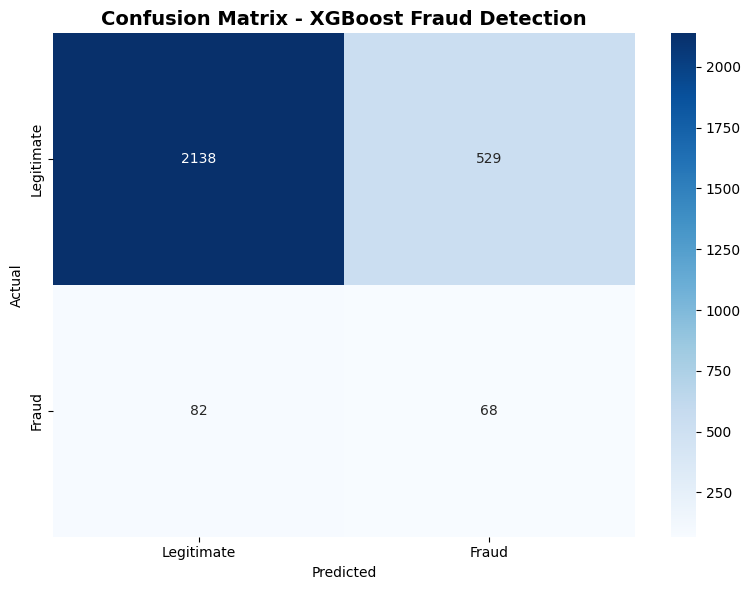


✅ SIGNIFICANT IMPROVEMENT over logistic regression!
   - Now detecting 68 fraud cases (was 0)
   - Precision: 11.4% (was 0%)
   - Recall: 45.3% (was 0%)


In [36]:
print("="*50)
print("MODEL PERFORMANCE")
print("="*50)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nAccuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"F1-Score:  {f1*100:.2f}%")
print(f"ROC-AUC:   {roc_auc:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\n--- Confusion Matrix ---")
print(f"True Negatives:  {tn:,}")
print(f"False Positives: {fp:,}")
print(f"False Negatives: {fn:,}")
print(f"True Positives:  {tp:,}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'])
plt.title('Confusion Matrix - XGBoost Fraud Detection', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\n✅ SIGNIFICANT IMPROVEMENT over logistic regression!")
print(f"   - Now detecting {tp} fraud cases (was 0)")
print(f"   - Precision: {precision*100:.1f}% (was 0%)")
print(f"   - Recall: {recall*100:.1f}% (was 0%)")

FEATURE IMPORTANCE

--- Top Risk Factors ---
                     feature  importance
1                 is_weekend    0.674746
0                     amount    0.130271
4          days_since_signup    0.107218
3            is_new_customer    0.087765
2              is_high_value    0.000000
5  shipping_billing_mismatch    0.000000


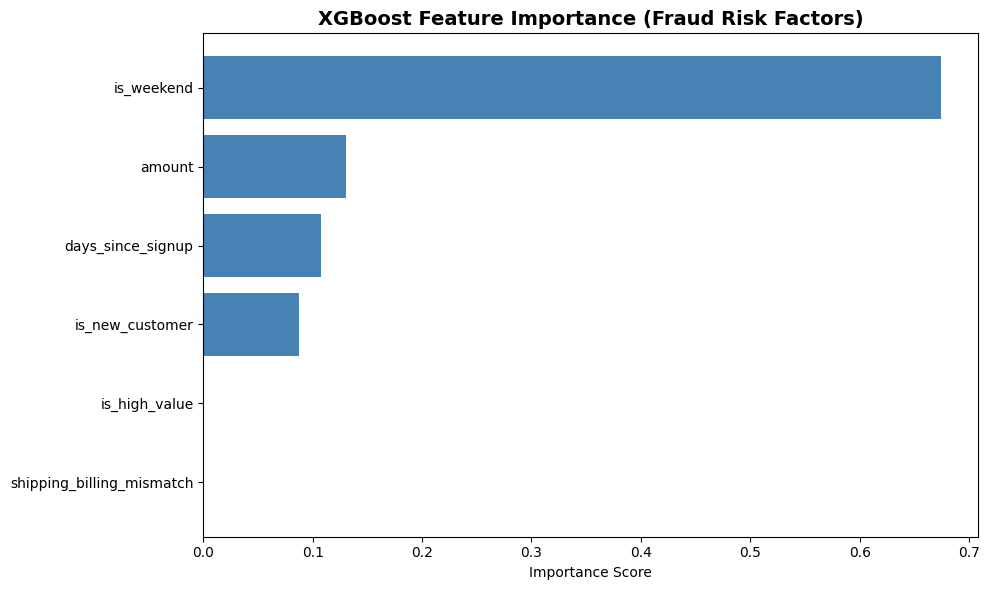


Top fraud indicators:
  1. is_weekend
  2. amount
  3. days_since_signup


In [37]:
print("="*50)
print("FEATURE IMPORTANCE")
print("="*50)

# Get feature importance from XGBoost
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- Top Risk Factors ---")
print(feature_importance)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importance Score')
plt.title('XGBoost Feature Importance (Fraud Risk Factors)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop fraud indicators:")
for i in range(min(3, len(feature_importance))):
    print(f"  {i+1}. {feature_importance.iloc[i]['feature']}")

In [38]:
print("="*50)
print("BUSINESS IMPACT ANALYSIS (XGBoost Model)")
print("="*50)

THRESHOLD = 0.5  # You can adjust this (0.3-0.7 range)

# Predictions based on threshold
probs = model.predict_proba(X_test_scaled)[:, 1]
y_pred_impact = (probs >= THRESHOLD).astype(int)

# Financial assumptions
avg_fraud_val = transactions[transactions['is_fraud'] == True]['amount'].mean()
cost_per_review = 25.00  # Cost for human review

# Calculate components
tp = np.sum((y_test == 1) & (y_pred_impact == 1))
fp = np.sum((y_test == 0) & (y_pred_impact == 1))
fn = np.sum((y_test == 1) & (y_pred_impact == 0))

fraud_caught_value = tp * avg_fraud_val
review_cost = fp * cost_per_review
fraud_missed_value = fn * avg_fraud_val

net_savings = fraud_caught_value - review_cost

# Extrapolate to quarterly
dataset_scale_factor = len(transactions) / len(y_test)
projected_quarterly_savings = net_savings * dataset_scale_factor

print(f"Threshold Used: {THRESHOLD}")
print(f"Average Fraud Value: ${avg_fraud_val:,.2f}")
print(f"\n--- Operational Impact (Test Set) ---")
print(f"Transactions Flagged for Review: {tp + fp}")
print(f"  ├─ True Fraud Caught: {tp}")
print(f"  └─ False Positives: {fp}")
print(f"\nFraud Detected (Value): ${fraud_caught_value:,.2f}")
print(f"Operational Cost of Reviews: -${review_cost:,.2f}")
print(f"Fraud Missed (Value): ${fraud_missed_value:,.2f}")
print("-" * 50)
print(f"NET SAVINGS (Test Batch): ${net_savings:,.2f}")
print(f"PROJECTED QUARTERLY SAVINGS: ${projected_quarterly_savings:,.2f}")

BUSINESS IMPACT ANALYSIS (XGBoost Model)
Threshold Used: 0.5
Average Fraud Value: $661.87

--- Operational Impact (Test Set) ---
Transactions Flagged for Review: 597
  ├─ True Fraud Caught: 68
  └─ False Positives: 529

Fraud Detected (Value): $45,007.46
Operational Cost of Reviews: -$13,225.00
Fraud Missed (Value): $54,273.70
--------------------------------------------------
NET SAVINGS (Test Batch): $31,782.46
PROJECTED QUARTERLY SAVINGS: $158,878.46


In [39]:
import joblib

# Save model and scaler
joblib.dump(model, FRAUD_MODEL)
joblib.dump(scaler, SCALER)
print("✅ Model and scaler saved successfully")

# Generate predictions for full dataset
all_predictions = model.predict(scaler.transform(X))
all_probabilities = model.predict_proba(scaler.transform(X))[:, 1]

# Add to dataframe
transactions['fraud_prediction'] = all_predictions
transactions['fraud_probability'] = all_probabilities

# Save updated transactions_clean.csv (for Power BI)
transactions.to_csv(TRANSACTIONS_CLEAN, index=False)
print(f"✅ Updated {TRANSACTIONS_CLEAN.name} with fraud predictions")
print(f"   Total Flagged: {all_predictions.sum()}")

# Also save as fraud_flagged.csv (for database/analysis)
fraud_flagged = transactions.copy()
fraud_flagged.to_csv(FRAUD_FLAGGED, index=False)
print(f"✅ Saved {FRAUD_FLAGGED.name}")

✅ Model and scaler saved successfully
✅ Updated transactions_clean.csv with fraud predictions
   Total Flagged: 3186
✅ Saved fraud_flagged.csv
